In [1]:
%run ../notebook/notebook_setup.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from config.config import RAVDESS
import librosa
import librosa.display
import IPython.display as ipd

In [2]:
# load the audio files

audio_files = list(RAVDESS.rglob("*.wav"))
print(f"Total length of the audio files: {len(audio_files)}")

Total length of the audio files: 2880


### Preprocessing

In [3]:
import random

random_audio_file = random.choice(audio_files)
print(f"Random audio file: {random_audio_file}")

Random audio file: /home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_06/03-01-04-02-01-01-06.wav


In [4]:
# Load audio on librosa

audio, sr = librosa.load(random_audio_file, sr=16000, mono=True)

In [5]:
ipd.Audio(audio, rate=sr)

In [6]:
# Trim Silience

trimmed_audio, _ = librosa.effects.trim(audio)

In [7]:
ipd.Audio(trimmed_audio, rate=sr)

In [8]:
# Normalize the audio
normalized_audio = librosa.util.normalize(trimmed_audio)

In [9]:
ipd.Audio(normalized_audio, rate=sr)

In [10]:
# Fix duration of audio length

desired_length = 3 * sr

fix_audio = librosa.util.fix_length(normalized_audio, size=desired_length)

In [11]:
# Now extract the mfcc

mfcc = librosa.feature.mfcc(y=fix_audio, sr=sr, n_mfcc=40)

In [12]:
# Fixed the mfcc
fixed_mfcc = librosa.util.fix_length(mfcc, size=300, axis=1)

In [13]:
fixed_mfcc.shape

(40, 300)

Text(0.5, 1.0, 'Mfcc of Audio')

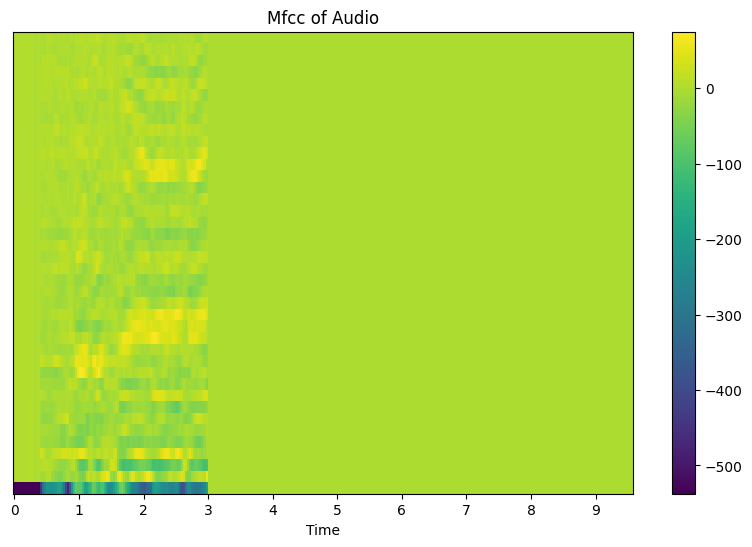

In [14]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(fixed_mfcc, sr=sr, x_axis="time", cmap="viridis")
plt.colorbar()
plt.title("Mfcc of Audio")

In [15]:
# delta and delta-delta from fixed mfcc

delta = librosa.feature.delta(fixed_mfcc)
delta2 = librosa.feature.delta(fixed_mfcc, order=2)

In [16]:
# Now stack them
features = np.vstack([fixed_mfcc, delta, delta2])

In [17]:
emotion_labels = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}

def get_label(file_path):
    parts = file_path.stem.split("-")
    emotion_code = parts[2]
    return emotion_labels[emotion_code]

In [18]:
labels = [get_label(file) for file in audio_files]

In [19]:
X = np.array(features)
y = np.array(labels)

In [20]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

y_encoded = label_encoder.fit_transform(y)

In [21]:
y_encoded, X.shape

(array([2, 1, 5, ..., 6, 4, 2], shape=(2880,)), (120, 300))

In [22]:
audio_files

[PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-07-01-01-01-13.wav'),
 PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-02-01-02-01-13.wav'),
 PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-01-01-02-01-13.wav'),
 PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-05-01-01-01-13.wav'),
 PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-08-02-02-01-13.wav'),
 PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-03-02-02-02-13.wav'),
 PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-06-02-02-01-13.wav'),
 PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-06-01-02-02-13.wav'),
 PosixPath('/home/inventor/Speech Emotion Recognition/data/raw/RAVDESS/Actor_13/03-01-05-01-02-01-13.wav'),
 PosixPath('/home/inventor/S

In [23]:
def preprocessing(file_path, desired_length=3*16000, n_mfcc=40, fixed_frames=300):

    # Load audio files 
    audio, sr = librosa.load(file_path, sr=16000, mono=True)

    # Trim silence
    trimmed_audio, _ = librosa.effects.trim(audio)

    # Normalize the audio
    normalized_audio = librosa.util.normalize(trimmed_audio)

    # Fix duration of audio length
    fix_audio = librosa.util.fix_length(normalized_audio, size=desired_length)

    # Extract the mfcc
    mfcc = librosa.feature.mfcc(y=fix_audio, sr=sr, n_mfcc=n_mfcc)

    # Fixed the mfcc
    fixed_mfcc = librosa.util.fix_length(mfcc, size=fixed_frames, axis=1)

    # delta and delta-detla from fix mfcc
    delta = librosa.feature.delta(fixed_mfcc)

    delta2 = librosa.feature.delta(fixed_mfcc, order=2)

    # Now stack them
    features = np.vstack([fixed_mfcc, delta, delta2])

    return features

    




In [24]:
X = []

for file in audio_files:

    feature = preprocessing(file)
    X.append(feature)

In [27]:
X = np.array(X)

In [28]:
X.shape

(2880, 120, 300)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)